# Homework 2 - Car Price Prediction Multiple Linear Regression
- source: https://www.kaggle.com/datasets/hellbuoy/car-price-prediction/code

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif
from sklearn.feature_selection import f_regression,mutual_info_regression,mutual_info_classif
from sklearn.feature_selection import SelectFromModel,RFE,VarianceThreshold

## Preprocessing
- 数据读取
- 数据预处理(处理空值等)
- 训练集 & 测试集划分

In [2]:
'''
Preprocessing
 - 数据读取
'''
data = pd.read_csv("CarPrice_Assignment.csv")
df = data.copy()

In [3]:
'''
Preprocessing
 - 空值处理
'''
df.info() #没有空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [4]:
'''
Preprocessing
 - 去除无意义数据列：car_ID
'''
df = df.drop('car_ID', axis=1)


'''
Preprocessing
 - Feature & Target split
'''
y = df["price"] # feature
X = df.drop('price', axis=1) # ground truth

## Feature Engineering 

1. *数据含义出发：*
- 从feature中去除car_ID列（无实际意义）


2. *连续型变量:*
- Variance threshold（方差阈值）：防止数据的方差过小，从而导致无意义
- KBest方法: 选择最佳的K个特征
- 相关性分析


3. *离散变量*：
- 描述性统计

In [5]:
'''
Feature Engineering (特征工程) —— 连续型变量
- 方差阈值：variance threshold'
- KBest方法：通过一个简单的linear function判断各个feature与target的相关性
'''

def variance_threshold(X_train, threshold=0):
    '''设置方差阈值'''
    vth = VarianceThreshold(threshold=threshold)  # as deafult threshold=0
    vth.fit(X_train)
    X_train_vth = X_train.iloc[:, vth.get_support()]
    return pd.DataFrame({'Feature': X_train.columns,
                         'Variance': vth.variances_,}).sort_values('Variance', ascending=True)


def select_K_best(X_train, y_train, k=6, train_set=True):
    '''KBest方法'''
    Kbest_reg = SelectKBest(score_func=f_regression, k=k)
    Kbest_reg.fit(X_train, y_train)
    
    # plot the scorez
    if train_set:
        plt.bar([X_train.columns[i] for i in range(len(Kbest_reg.scores_))], 
                Kbest_reg.scores_)
        plt.xticks(rotation=90)
        plt.rcParams["figure.figsize"] = (8,6)
        plt.show()
    
    return Kbest_reg

In [6]:
X_continuous = X[["wheelbase", "carlength", "carwidth", 
                  "carheight", "curbweight", "enginesize", "boreratio",
                  "stroke", "compressionratio", "horsepower", "peakrpm",
                  "citympg", "highwaympg"]]

# variance threshold
variance_threshold(X_continuous, threshold=0)

,Feature,Variance
6,boreratio,0.072998
7,stroke,0.097863
2,carwidth,4.579451
3,carheight,5.941674
8,compressionratio,15.700143
0,wheelbase,34.300000
11,citympg,36.000000
12,highwaympg,38.000000
1,carlength,67.000000
9,horsepower,240.000000


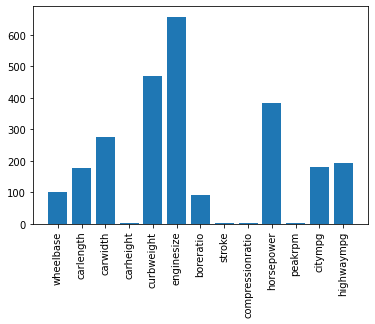

In [7]:
_ = select_K_best(X_continuous, y)

**分类变量的Feature Engineering**

In [8]:
X_cls = df.drop(["wheelbase", "carlength", "carwidth", 
                 "carheight", "curbweight", "enginesize", 
                 "boreratio", "stroke", "compressionratio",
                 "horsepower", "peakrpm", "citympg", "highwaympg"], axis=1)

X_cls.head(5)

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,dohc,four,mpfi,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,dohc,four,mpfi,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,ohc,four,mpfi,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,ohc,five,mpfi,17450.0


描述性统计

In [9]:
def column_countplot(ax, column, df):
    column_cls_list = df[column].unique()
    cls_list_num = [len(df[df[column] == each_cls]) for each_cls 
                    in column_cls_list]
    ax.set_title('{} bar plot'.format(column))
    ax.bar(column_cls_list, cls_list_num)
    return ax

CLS column number:12


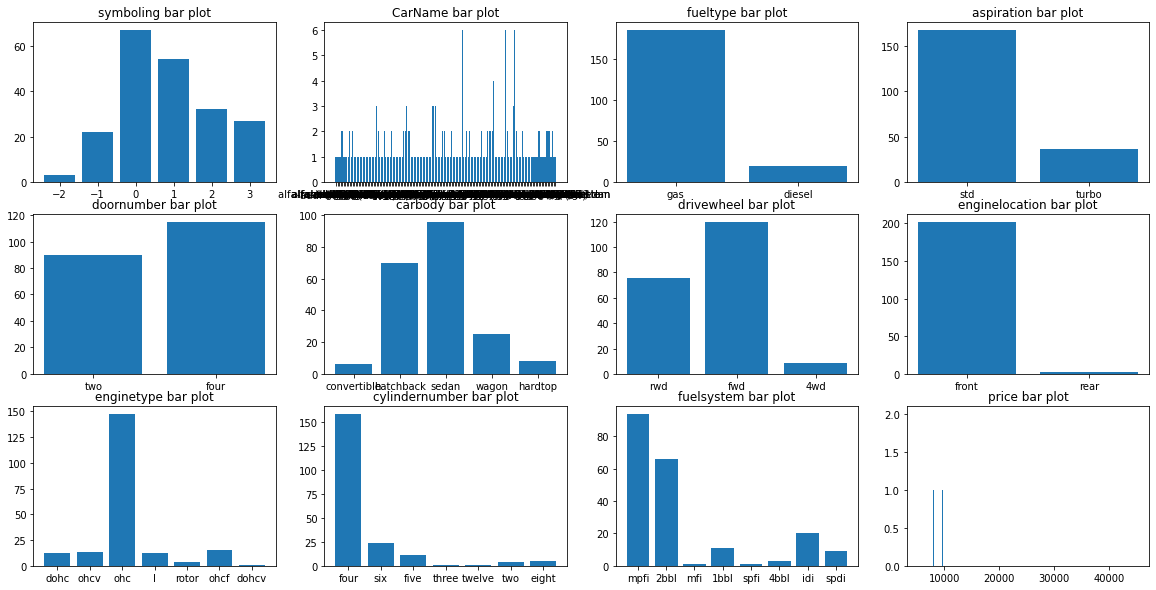

In [10]:
print("CLS column number:{}".format(len(X_cls.columns)))
f, axs = plt.subplots(3,4, figsize=(20,10))
for i in range(3):
    for j in range(4):
        axs[i][j] = column_countplot(axs[i][j], 
                                     X_cls.columns[int(i*4 + j)], df)
plt.show()

**Correlation Matrix**

C:\Users\19436\AppData\Local\Temp\ipykernel_21852\302231840.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True, mask=np.triu(data.corr(),k=1))


<AxesSubplot:>

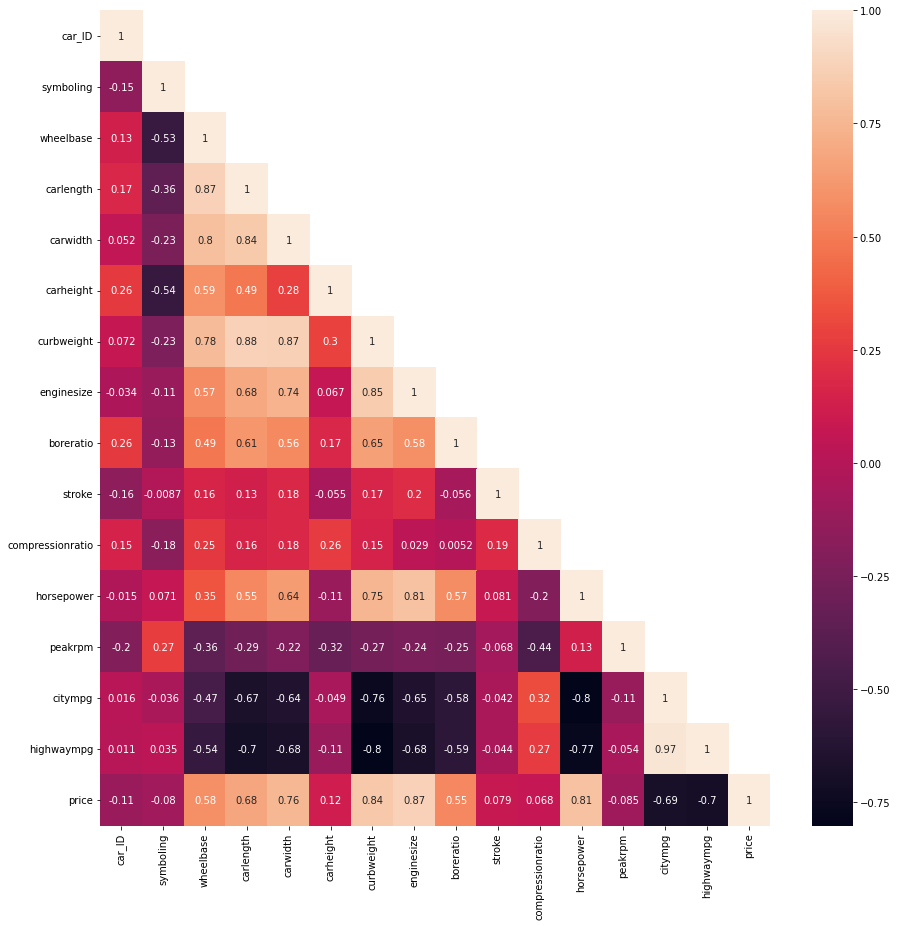

In [11]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True, mask=np.triu(data.corr(),k=1))

**Price Distribution**

C:\Users\19436\AppData\Local\Temp\ipykernel_21852\137551471.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['price'],color="y")


<AxesSubplot:xlabel='price', ylabel='Density'>

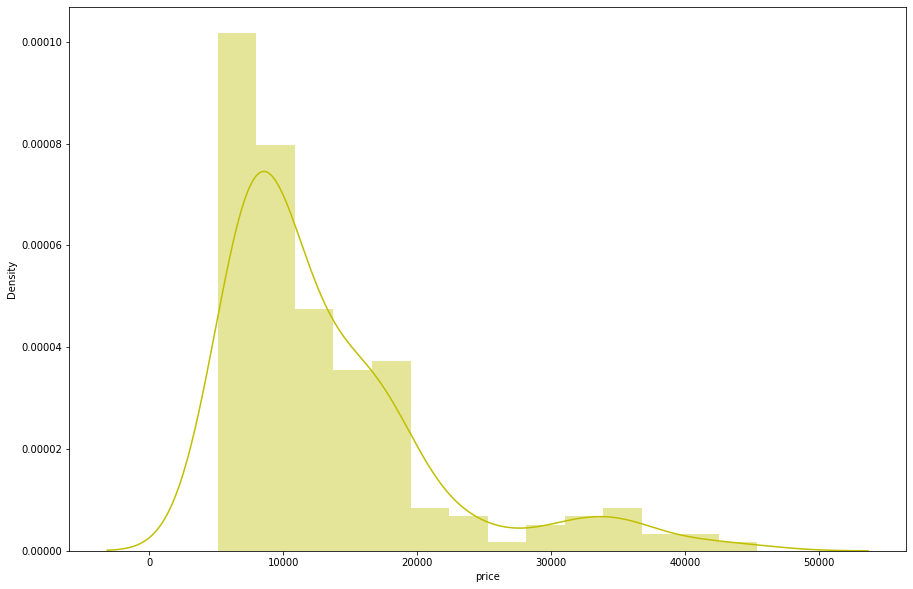

In [12]:
plt.figure(figsize=(15,10))
sns.distplot(data['price'],color="y")

## 任务一
- 对因变量price建立【两个】合适的回归模型，可选择的模型包括基础线性回归模型、岭回归及Lasso等
- 并从多个角度对比评价这两个模型，如可解释程度、拟合程度、预测精度等。

## **Linear Regression Model**

- Feature Engineering
- Normalize the feature
- train test split
- linear regression - 基础线性回归
- linear regression - lasso回归

In [13]:
'''
Linear Regression Model
- Feature Engineering
- 根据Feature Engineering情况 选择合适的特征
'''
X_data = X.copy()
y_data = y.copy()

X_data.drop(['CarName', 'fueltype', 'aspiration', 'peakrpm', 
             'carheight', 'compressionratio', 'stroke'], 
            axis=1, inplace=True)

X_data= pd.get_dummies(X_data) # 转换类别变量为one-hot
X_data.head(5)

,symboling,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,...,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,3,88.6,168.8,64.1,2548,130,3.47,111,21,27,...,0,0,0,0,0,0,0,1,0,0
1,3,88.6,168.8,64.1,2548,130,3.47,111,21,27,...,0,0,0,0,0,0,0,1,0,0
2,1,94.5,171.2,65.5,2823,152,2.68,154,19,26,...,0,0,0,0,0,0,0,1,0,0
3,2,99.8,176.6,66.2,2337,109,3.19,102,24,30,...,0,0,0,0,0,0,0,1,0,0
4,2,99.4,176.6,66.4,2824,136,3.19,115,18,22,...,0,0,0,0,0,0,0,1,0,0


In [14]:
'''
Linear Regression Model
- Normalize the feature
'''
X_data_value = Normalizer().fit_transform(X_data.values)
X_data = pd.DataFrame(X_data_value, columns=[X_data.columns])


'''
Linear Regression Model
- train test split
'''
X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    y_data, 
                                                    random_state=17, 
                                                    test_size=.30)
print("Train set size: {}".format(len(X_train)))
print("Test set size: {}".format(len(X_test)))

Train set size: 143
Test set size: 62


**Linear Regression**

In [15]:
'''
Linear Regression Model
- linear regression - 基础线性回归
'''

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train) # 线性模型

0.9452339112176131

**Ridge Regression**

In [16]:
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_train, y_train)

0.04432237557264285

## **Evaluation**

**预测精度**

In [17]:
def mean_squared_error(y_true, y_predict):
    """计算y_true和y_predict之间的MSE"""
    assert len(y_true) == len(y_predict), \
        "the size of y_true must be equal to the size of y_predict"
    return np.sum((y_true - y_predict) ** 2) / len(y_true)

def root_mean_squared_error(y_true, y_predict):
    """计算y_true和y_predict之间的RMSE"""
    return np.sqrt(mean_squared_error(y_true, y_predict))

def mean_absolute_error(y_true, y_predict):
    """计算y_true和y_predict之间的MAE"""
    assert len(y_true) == len(y_predict), \
        "the size of y_true must be equal to the size of y_predict"

    return np.sum(np.absolute(y_predict - y_true)) / len(y_predict)

In [18]:
print("*****LINEAR REGRESSION MDOEL*****")
y_pred = linear_regression.predict(X_test)

print("Mean Squared Error: {}".format(mean_squared_error(y_test.values, y_pred)))
print("Root MSE: {}".format(root_mean_squared_error(y_test.values, y_pred)))
print("Mean Absolute Error: {}".format(mean_absolute_error(y_test.values, y_pred)))

*****LINEAR REGRESSION MDOEL*****
Mean Squared Error: 13494204.284224717
Root MSE: 3673.4458324881716
Mean Absolute Error: 2373.8299347143525


In [19]:
print("*****LASSO LINEAR REGRESSION MDOEL*****")
y_pred = ridge_regressor.predict(X_test)

print("Mean Squared Error: {}".format(mean_squared_error(y_test.values, y_pred)))
print("Root MSE: {}".format(root_mean_squared_error(y_test.values, y_pred)))
print("Mean Absolute Error: {}".format(mean_absolute_error(y_test.values, y_pred)))

*****LASSO LINEAR REGRESSION MDOEL*****
Mean Squared Error: 67849937.45448232
Root MSE: 8237.1073475148
Mean Absolute Error: 5885.363973004948


**拟合程度**

In [20]:
print("简单线性回归拟合优度： {}".format(linear_regression.score(X_train, y_train)))
print("岭回归拟合优度： {}".format(ridge_regressor.score(X_train, y_train)))

简单线性回归拟合优度： 0.9452339112176131
岭回归拟合优度： 0.04432237557264285


## 任务2

- 自定义指标将price转换为一个二分类指标，如根据中位数划将数据分为高价格/低价格
- 对二分类因变量建立逻辑回归模型
- 对模型结果进行解读并对模型进行评价。

In [21]:
X_data = X.copy()
y_data = y.copy()

X_data.drop(['CarName', 'fueltype', 'aspiration', 'peakrpm', 
             'carheight', 'compressionratio', 'stroke'], 
            axis=1, inplace=True)

X_data= pd.get_dummies(X_data) # 转换类别变量为one-hot

In [31]:
'''
将price根据平均值转为类别变量
'''
price_mean = np.mean(y_data)

y_cls = y.apply(lambda x: 1 if x > price_mean else 0)


'''
train_test_split
'''
X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    y_cls, 
                                                    random_state=17, 
                                                    test_size=.30)

In [34]:
'''
建立逻辑回归模型
'''
clf = LogisticRegression(max_iter=1000,random_state=17).fit(X_train, y_train)

In [38]:
'''
模型结果：
系数的绝对值越大，表明该特征与价格的相关性越大
+ 系数：表明该特征与价格为正相关
- 系数：表明该特征与价格负相关
'''
for i in range(len(X_train.columns)):
    print("{}: {}".format(X_train.columns[i] ,clf.coef_[0][i]))

symboling: 0.25087833086309747
wheelbase: -0.009593573635594497
carlength: -0.08317263157985547
carwidth: -0.22801001609468224
curbweight: 0.011955700718580878
enginesize: -0.031956436208924965
boreratio: -0.6998319276412264
horsepower: 0.021947437630631145
citympg: -0.3870064383606393
highwaympg: 0.40722508211536246
doornumber_four: -0.24986362644234603
doornumber_two: 0.22633240932379228
carbody_convertible: 0.34222583317577376
carbody_hardtop: -0.42969325927020047
carbody_hatchback: -0.7266270661972069
carbody_sedan: 0.8668177564835877
carbody_wagon: -0.07625448128238042
drivewheel_4wd: -0.12022532416035067
drivewheel_fwd: 0.0056052500021956655
drivewheel_rwd: 0.09108885703350654
enginelocation_front: -0.051933048050310744
enginelocation_rear: 0.028401830929064367
enginetype_dohc: 0.5259139179099438
enginetype_dohcv: 0.00020881853200469704
enginetype_l: -0.8581822182760649
enginetype_ohc: 0.3348317487986712
enginetype_ohcf: -0.18536813853976578
enginetype_ohcv: 0.06254845009999119
e

In [41]:
'''评价模型性能'''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = clf.predict(X_test)

print("Precision: {}".format(precision_score(y_test, y_pred)))
print("Recall: {}".format(precision_score(y_test, y_pred)))
print("F1 Score: {}".format(precision_score(y_test, y_pred)))

print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Precision: 0.88
Recall: 0.88
F1 Score: 0.88
Confusion Matrix:
[[34  3]
 [ 3 22]]
